In [1]:
import tensorflow as tf
import keras
from keras.layers import Flatten,Dropout,AveragePooling2D,SeparableConv2D,ReLU,Input,BatchNormalization,GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Softmax
from keras.activations import sigmoid,softmax
from keras.models import Sequential, Model
# import visualkeras
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import random
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau,CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2024-04-25 19:25:07.332960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 19:25:07.333015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 19:25:07.334554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


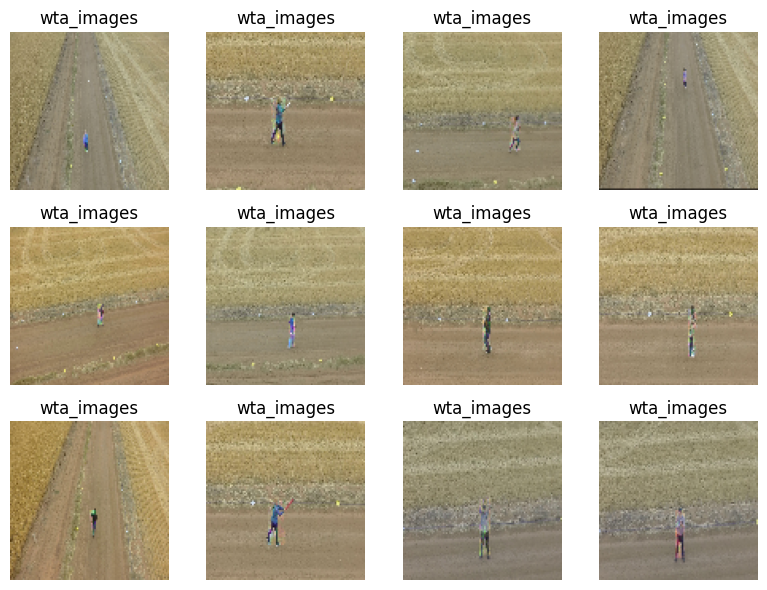

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to the root folders
root_folder = '/kaggle/input/da-data/DA_data/DA_train_data'
num_rows = 3
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 6))

# Function to recursively get all image files in a directory
def get_image_files(directory):
    image_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_files.append(os.path.join(root, file))
    return image_files

# Iterate over class folders
for i, class_folder in enumerate(os.listdir(root_folder)):
    if i >= num_rows * num_cols:
        break
    class_folder_path = os.path.join(root_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Iterate over subfolders in the class folder
        for subdir in os.listdir(class_folder_path):
            subdir_path = os.path.join(class_folder_path, subdir)
            if os.path.isdir(subdir_path):
                # Get image files from the subfolder
                image_files = get_image_files(subdir_path)
                if len(image_files) > 0:
                    # Load the first image in the subfolder
                    img_path = image_files[0]
                    img = cv2.imread(img_path)

                    # Resize the image to a fixed size (you can change this as needed)
                    img = cv2.resize(img, (100, 100))

                    # Display the image
                    row_index = i // num_cols
                    col_index = i % num_cols
                    axes[row_index, col_index].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    axes[row_index, col_index].set_title(subdir)
                    axes[row_index, col_index].axis('off')
                    i += 1
                    if i >= num_rows * num_cols:
                        break
plt.tight_layout()
plt.show()


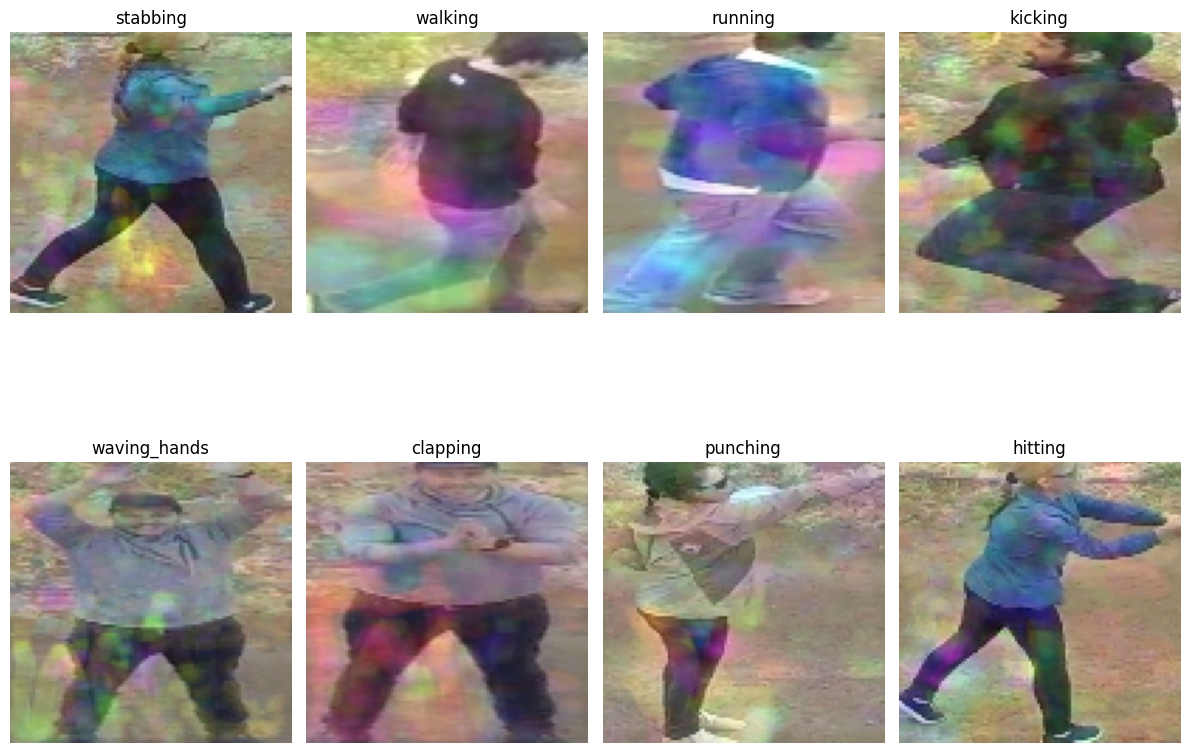

In [3]:

# Paths to the root folders
root_folder = "/kaggle/input/da-revised-classes/DA_revised_classes"
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, class_folder in enumerate(os.listdir(root_folder)):
    if i >= num_rows * num_cols:
        break
    class_folder_path = os.path.join(root_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Get the first image in the class folder
        image_names = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        if len(image_names) > 0:
            image_path = os.path.join(class_folder_path, image_names[0])
            img = cv2.imread(image_path)

            # Resize the image to a fixed size (you can change this as needed)
            img = cv2.resize(img, (100, 100))

            # Display the image
            row_index = i // num_cols
            col_index = i % num_cols
            axes[row_index, col_index].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[row_index, col_index].set_title(class_folder)
            axes[row_index, col_index].axis('off')

plt.tight_layout()
plt.show()


In [4]:
def load_and_preprocess_images(images_path, target_size=(224, 224)):
    images = []
    labels = []
    class_mapping = {}  # Mapping from class names to integer labels
    label_counter = 0

    for class_folder in os.listdir(images_path):
        class_folder_path = os.path.join(images_path, class_folder)
        if os.path.isdir(class_folder_path):
            class_mapping[class_folder] = label_counter
            label_counter += 1
            for filename in os.listdir(class_folder_path):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(class_folder_path, filename)
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Preprocess the image
                        img = cv2.resize(img, target_size)
                        img = img.reshape(target_size[0], target_size[1], 3)
#                         img = img.astype('float32') / 255.0  # Normalize pixel values
                        images.append(img)
                        labels.append(class_mapping[class_folder])

    return np.array(images), np.array(labels), class_mapping

In [5]:
train_data_path = "/kaggle/input/da-revised-classes/DA_revised_classes"
images,labels,class_mapping = load_and_preprocess_images(train_data_path, target_size=(224, 224))

In [6]:
from sklearn.model_selection import train_test_split
train_images = np.array(images)
train_labels = np.array(labels)

X_train,valid_img,y_train,valid_labels = train_test_split(train_images,train_labels,test_size=0.2,shuffle=True)
# temp = list(zip(train_images, train_labels))
# random.shuffle(temp)
# res1, res2 = zip(*temp)
# res1, res2 = list(res1), list(res2)

X_train = X_train / 255.0
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
valid_img = valid_img / 255.0
val_labels = valid_labels
valid_labels = tf.keras.utils.to_categorical(valid_labels, num_classes=num_classes)

In [7]:
X_train.shape,y_train.shape

((4000, 224, 224, 3), (4000, 8))

In [8]:
valid_img.shape,valid_labels.shape

((1000, 224, 224, 3), (1000, 8))

In [9]:
from tensorflow.keras.applications import InceptionV3
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=tf.keras.layers.Input(shape=(224,224,3)))
hmodel = bmodel.output
hmodel = tf.keras.layers.Flatten()(hmodel)
hmodel = tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(hmodel)
hmodel = tf.keras.layers.Dropout(0.5)(hmodel)
hmodel = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(hmodel)
hmodel = tf.keras.layers.Dropout(0.3)(hmodel)
hmodel = tf.keras.layers.BatchNormalization()(hmodel)
hmodel = tf.keras.layers.Dense(8,activation= 'softmax')(hmodel)
# 
inception_model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
inception_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# inception_model.summary()

In [12]:
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

history = inception_model.fit(
        X_train,y_train,
        validation_data = (valid_img,valid_labels),
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50
  3/125 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.1111 - loss: 5.0920 

I0000 00:00:1714073163.008718    1331 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714073163.060152    1331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2774 - loss: 4.9484

W0000 00:00:1714073177.597196    1334 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.2781 - loss: 4.9444 - val_accuracy: 0.5750 - val_loss: 3.0994 - learning_rate: 0.0010
Epoch 2/50
  2/125 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6250 - loss: 3.0542 

W0000 00:00:1714073186.409708    1334 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5528 - loss: 3.0062 - val_accuracy: 0.5880 - val_loss: 2.2966 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6239 - loss: 2.2418 - val_accuracy: 0.7280 - val_loss: 2.1024 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6239 - loss: 2.2302 - val_accuracy: 0.6680 - val_loss: 1.8972 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6710 - loss: 1.9526 - val_accuracy: 0.7290 - val_loss: 2.0031 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6405 - loss: 2.0726 - val_accuracy: 0.6400 - val_loss: 1.9738 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6586 - loss: 1.9417 - val_accuracy: 0.7310 - val_loss: 1.6807 - learning_rate: 0.0010
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6572 - loss: 1.9263 - val_

In [13]:
epochs = [i for i in range(1,50+1)]
loss_values = history.history['loss']
acc = history.history['accuracy']
vloss_values = history.history['val_loss']
vacc = history.history['val_accuracy']

/tmp/ipykernel_1284/3938258983.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
/tmp/ipykernel_1284/3938258983.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')


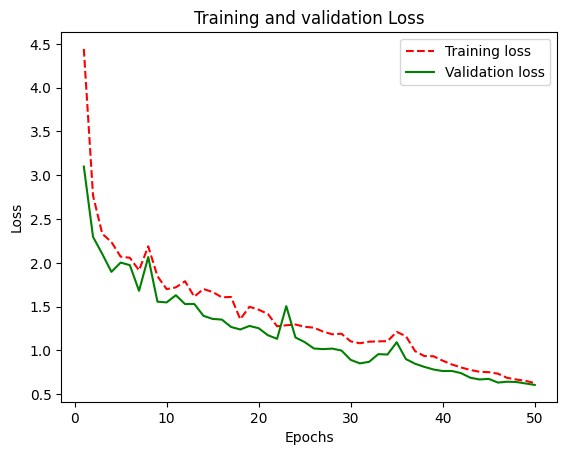

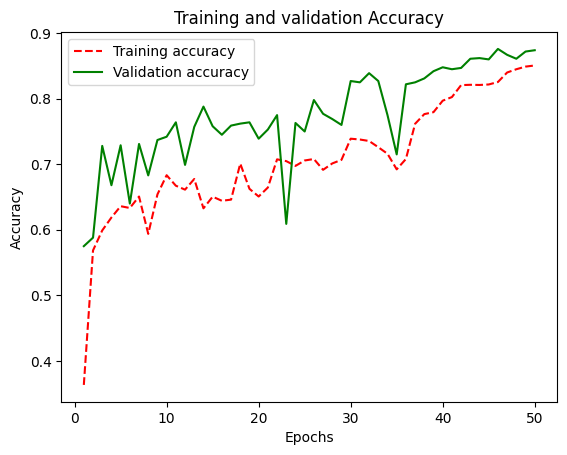

In [14]:
plt.plot(epochs, loss_values, '--', color = 'r',label='Training loss')
plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training_and_validation_Loss.png')

plt.figure()
plt.plot(epochs, acc, '--',color = 'r', label='Training accuracy')
plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Training_and_validation_acc.png')

plt.show()

In [15]:
inception_model.evaluate(valid_img,valid_labels)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8789 - loss: 0.6008


[0.6067948341369629, 0.8740000128746033]

In [16]:
predictions = inception_model.predict(valid_img)

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

W0000 00:00:1714073689.925125    1331 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step


W0000 00:00:1714073697.055771    1334 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
predicted_classes = np.argmax(predictions, axis=1)

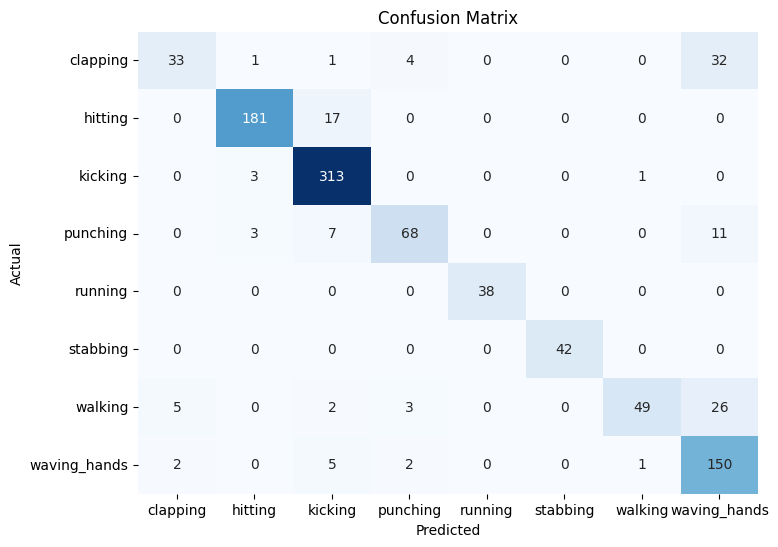

In [19]:
conf_mat = confusion_matrix(val_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["clapping", "hitting","kicking","punching","running","stabbing","walking","waving_hands"],
            yticklabels=["clapping", "hitting","kicking","punching","running","stabbing","walking","waving_hands"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('cf_matrix.png')
plt.show()

target_names = ["clapping", "hitting","kicking","punching","running","stabbing","walking","waving_hands"]
# print(classification_report(valid_labels, predicted_classes, target_names=target_names))

In [21]:
print(classification_report(val_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    clapping       0.82      0.46      0.59        71
     hitting       0.96      0.91      0.94       198
     kicking       0.91      0.99      0.95       317
    punching       0.88      0.76      0.82        89
     running       1.00      1.00      1.00        38
    stabbing       1.00      1.00      1.00        42
     walking       0.96      0.58      0.72        85
waving_hands       0.68      0.94      0.79       160

    accuracy                           0.87      1000
   macro avg       0.90      0.83      0.85      1000
weighted avg       0.89      0.87      0.87      1000

